# Lab 8 - K-Means Clustering

**Dataset Description**: You are required to apply a clustering technique for customer segmentation, in order to define a marketing strategy for a certain bank's credit card customers. The
sample dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.

The following is the explanation for the provided credit card dataset.
```raw
CUSTID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases

BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFFPURCHASES : Maximum purchase amount done in one-go

INSTALLMENTSPURCHASES : Amount of purchase done in installment

CASHADVANCE : Cash in advance given by the user

PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASESTRX : Number of purchase transactions made

CREDITLIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user
```

## Import Libraries and Load the Dataset

The data URL is `https://raw.githubusercontent.com/GUC-DM/W2021/main/data/cc_dataset.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [2]:
try:
    df = pd.read_csv('../data/cc_dataset.csv')
except:
    df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/W2021/main/data/cc_dataset.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data Inspection / Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
df.isnull().sum() / df.count() * 100

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.011174
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.623943
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

Since there are very few missing values, we can impute them with the median value without really affecting the data's overall distribution. A better alternative could be to impute with the value of similar records.

In [5]:
df = df.fillna(df.median())
df.isnull().any().any()

False

Since we won't be using the customer_ID in analysis or in the model, we'll drop it at this stage. In a production environment (i.e. if the model will be deployed and used by the organization), we'd need to keep the customer IDs somewhere so the organization can make use of the model and back-reference their details (e.g. for customized offers).

In [6]:
df = df.drop('CUST_ID', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

## Clustering

You should consider scaling the data to improve clustering performance. Features with a wide range of values often dominate the distance measure calculation, so using scaling would be advised. Consider the following techniques that were covered in previous lectures:

- Min-Max Normalization (uses min and max, often scaling values to 0..1)
- Z-Score Normalization (uses mean and stddev)

See https://scikit-learn.org/stable/modules/preprocessing.html for the relevant functions.

Keep the original dataframe for analysis in the next section.

In [7]:
from sklearn.preprocessing import StandardScaler

# !!Important note: if only a subset of the columns are numerical,
# or not all the values should be scaled, pass the desired subset of
# columns and assign them back using column indexing
# Always keep a copy of the dataframe before scaling for later plotting/analysis

scaled_data = StandardScaler().fit_transform(df)

# scikit-learn operates over numpy arrays
# since we passed the entire dataframe,
# and didn't assign the values back into their original columns,
# the resulting output is a numpy array

scaled_data

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.3024    ,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.09749953,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.0932934 ,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.32687479,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.33830497,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.3243581 ,
        -0.52555097, -4.12276757]])

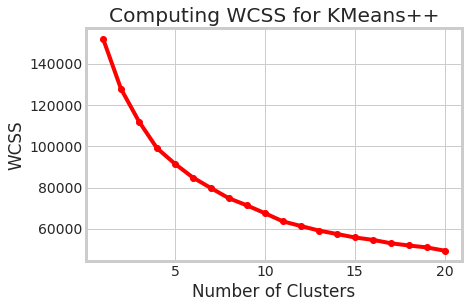

In [8]:
from sklearn.cluster import KMeans

# Use the Elbow method to find a good number of clusters using WCSS.
# We'll set the upper limit of k to 20 this time,
# to factor in the possibility of having 6 to 10 customer groups.
# Setting a higher number would cause time to run to increase,
# so some optimizations needs to considered for very large datasets

# !!Important Note: scale the upper limit with the number of groups you are expecting


wcss = []
for k in range( 1, 21 ):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit_predict(scaled_data)
    wcss.append( kmeans.inertia_ )
    
plt.plot(range(1, 21), wcss, 'o-r', label="WCSS")
plt.title("Computing WCSS for KMeans++")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

There may not always be a sharp elbow that can be easily idntified.
Thus, using other heuristics to determine the optimal number of clusters is advised (outside the scope of the course).

Further reading: https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

Ultimately, the choice of the number of clusters to use should be based on clustering evaluation metrics (e.g. elbow method, silhouette score, etc.) and domain knowledge. K-Means was applied using 6, 7, 8, 9 and 10 n_clusters, 9 was finally chosen due to the emergence of interpretable customer groups when `n_clusters` was set to 9.

In [9]:
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(scaled_data)

# As it's difficult to visualise clusters when the data is high-dimensional - we'll use
# boxplots to help us see how the clusters are grouping the samples

df["cluster"] = cluster_labels

## Cluster Interpretation

Compared to the main lab notebook, this data is highly dimensional and can not be plotted as simply on a single plot. Think of how you can investigate each cluster with respect to each column in the data.

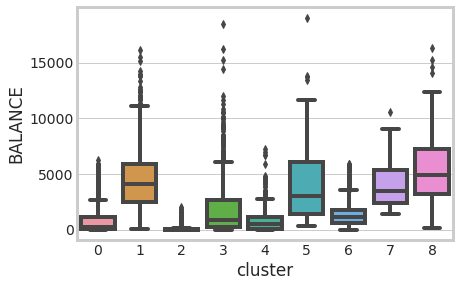

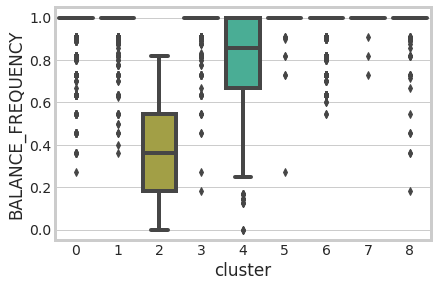

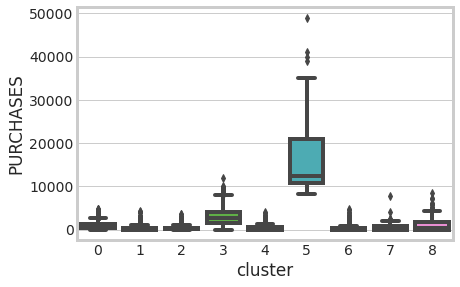

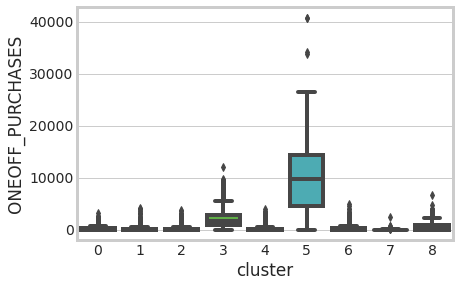

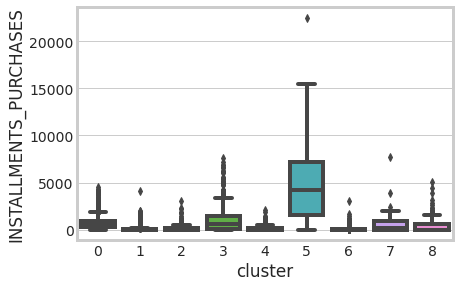

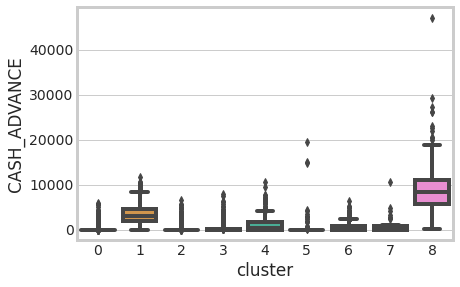

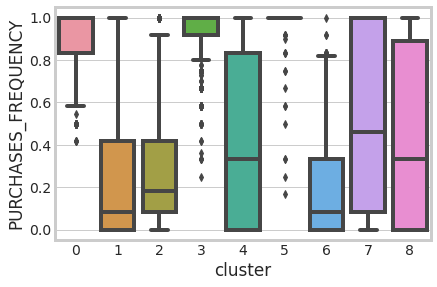

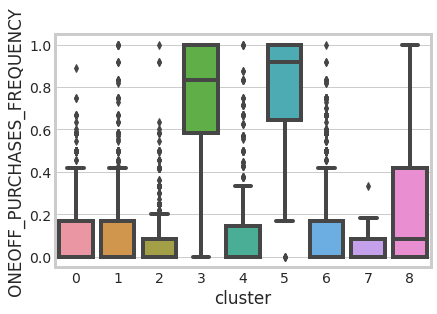

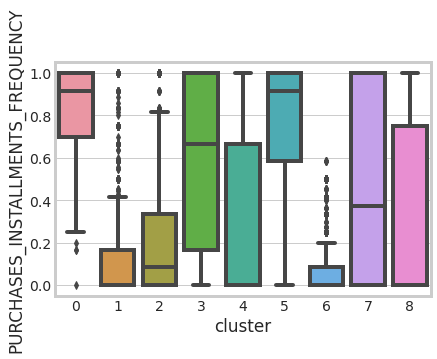

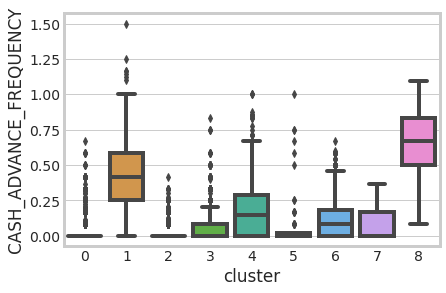

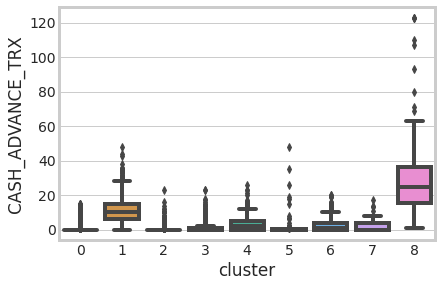

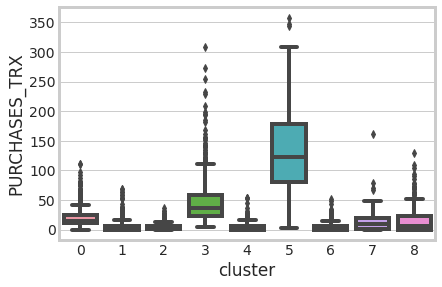

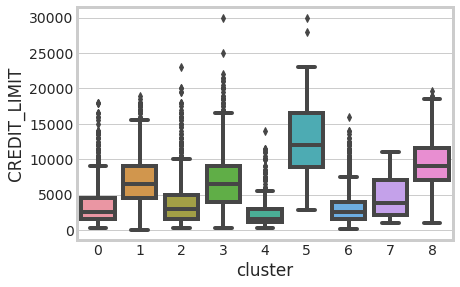

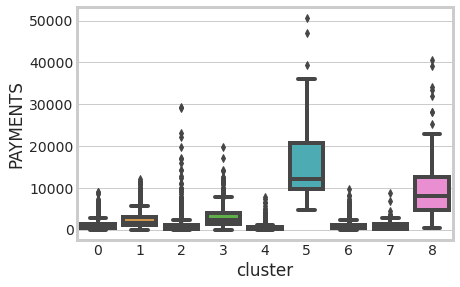

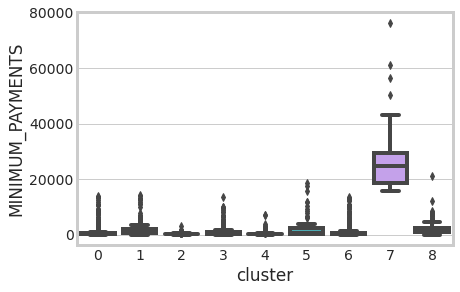

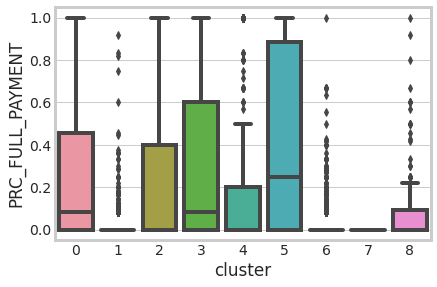

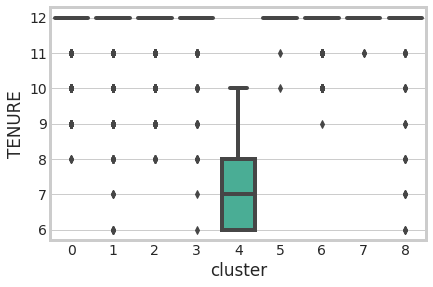

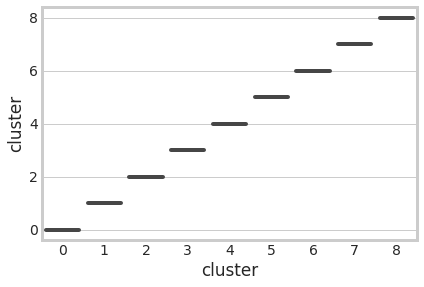

In [10]:
# Minimal code to plot a boxplot of each numerical column
# Categorical columns would need to be plotted differently
# (e.g. using a countplot)

for col in df.select_dtypes('number').columns:
    plt.figure()
    sns.boxplot(x='cluster', y=col, data=df)

/home/hazem/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


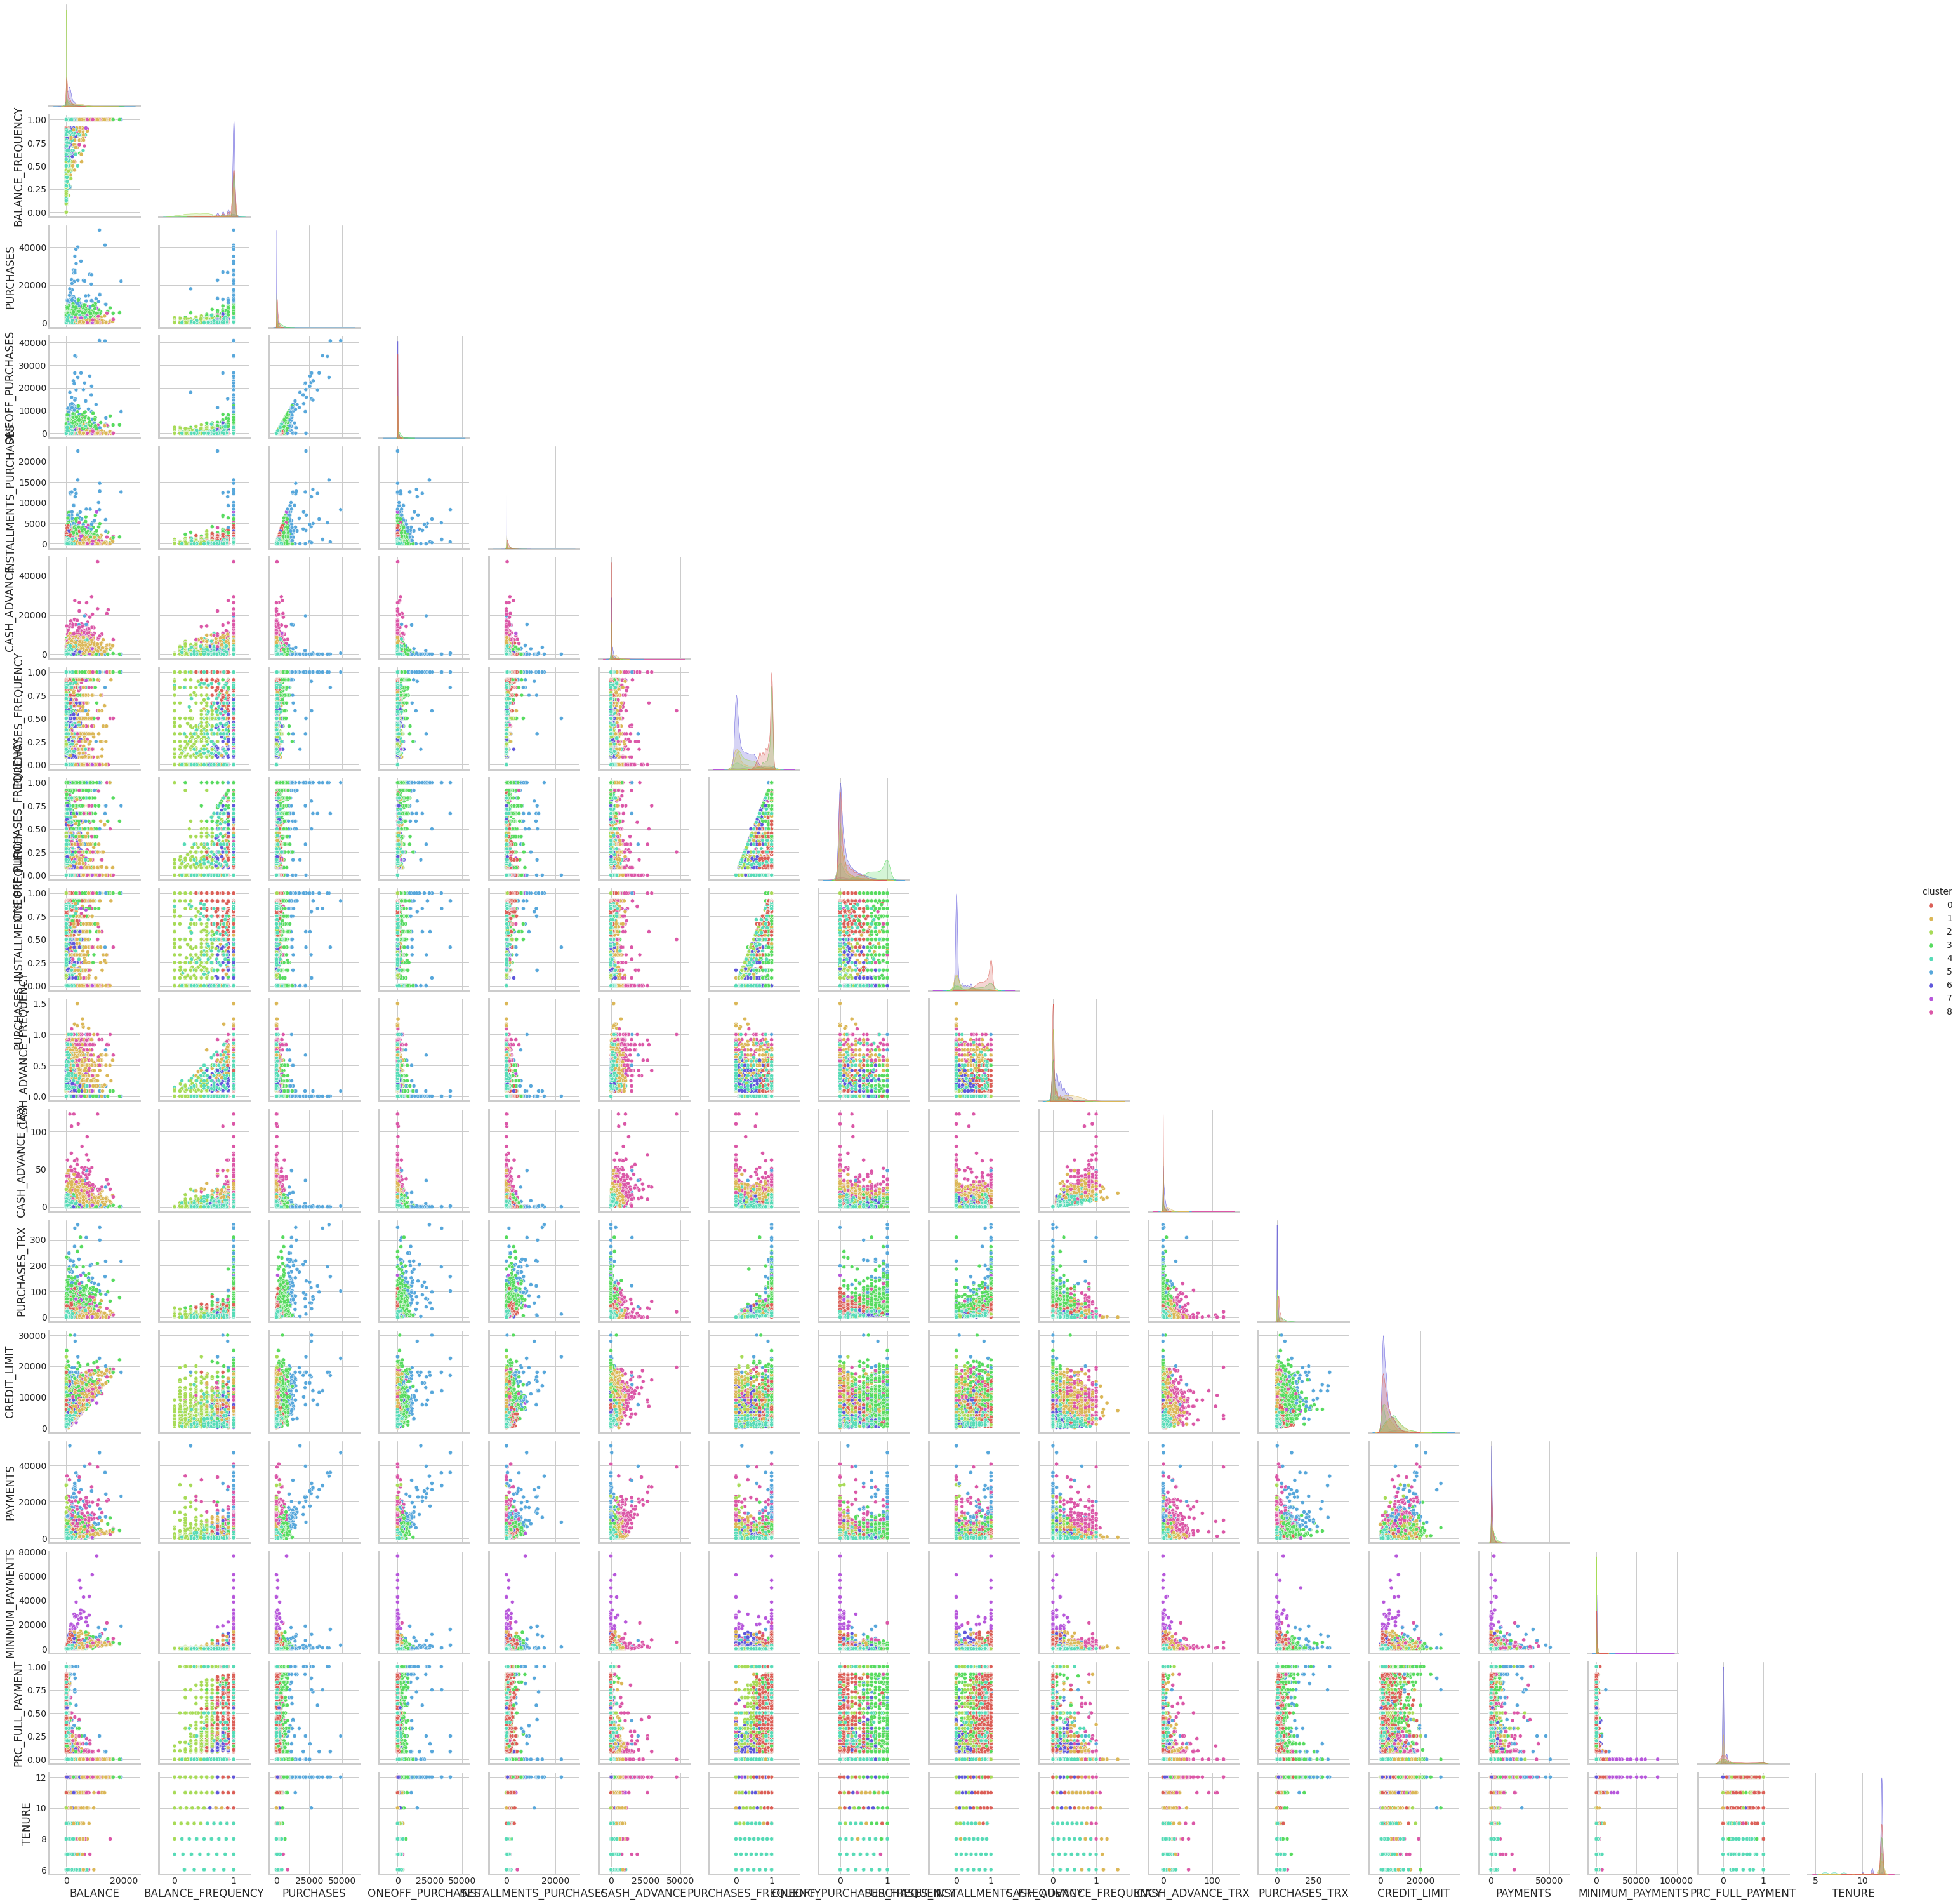

In [11]:
# Since there are many columns in the dataset, pairplot is hard to read
# Investigating using boxplots first and then pair/scatter plotting the interesting
# columns would be a better approach
sns.pairplot(df, hue='cluster', palette=sns.color_palette('hls', 9), corner=True)

<AxesSubplot:xlabel='cluster', ylabel='count'>

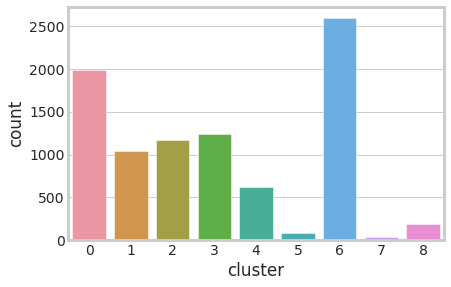

In [12]:
# Visually plotting how many points belong to each cluster 
sns.countplot(x='cluster', data=df)

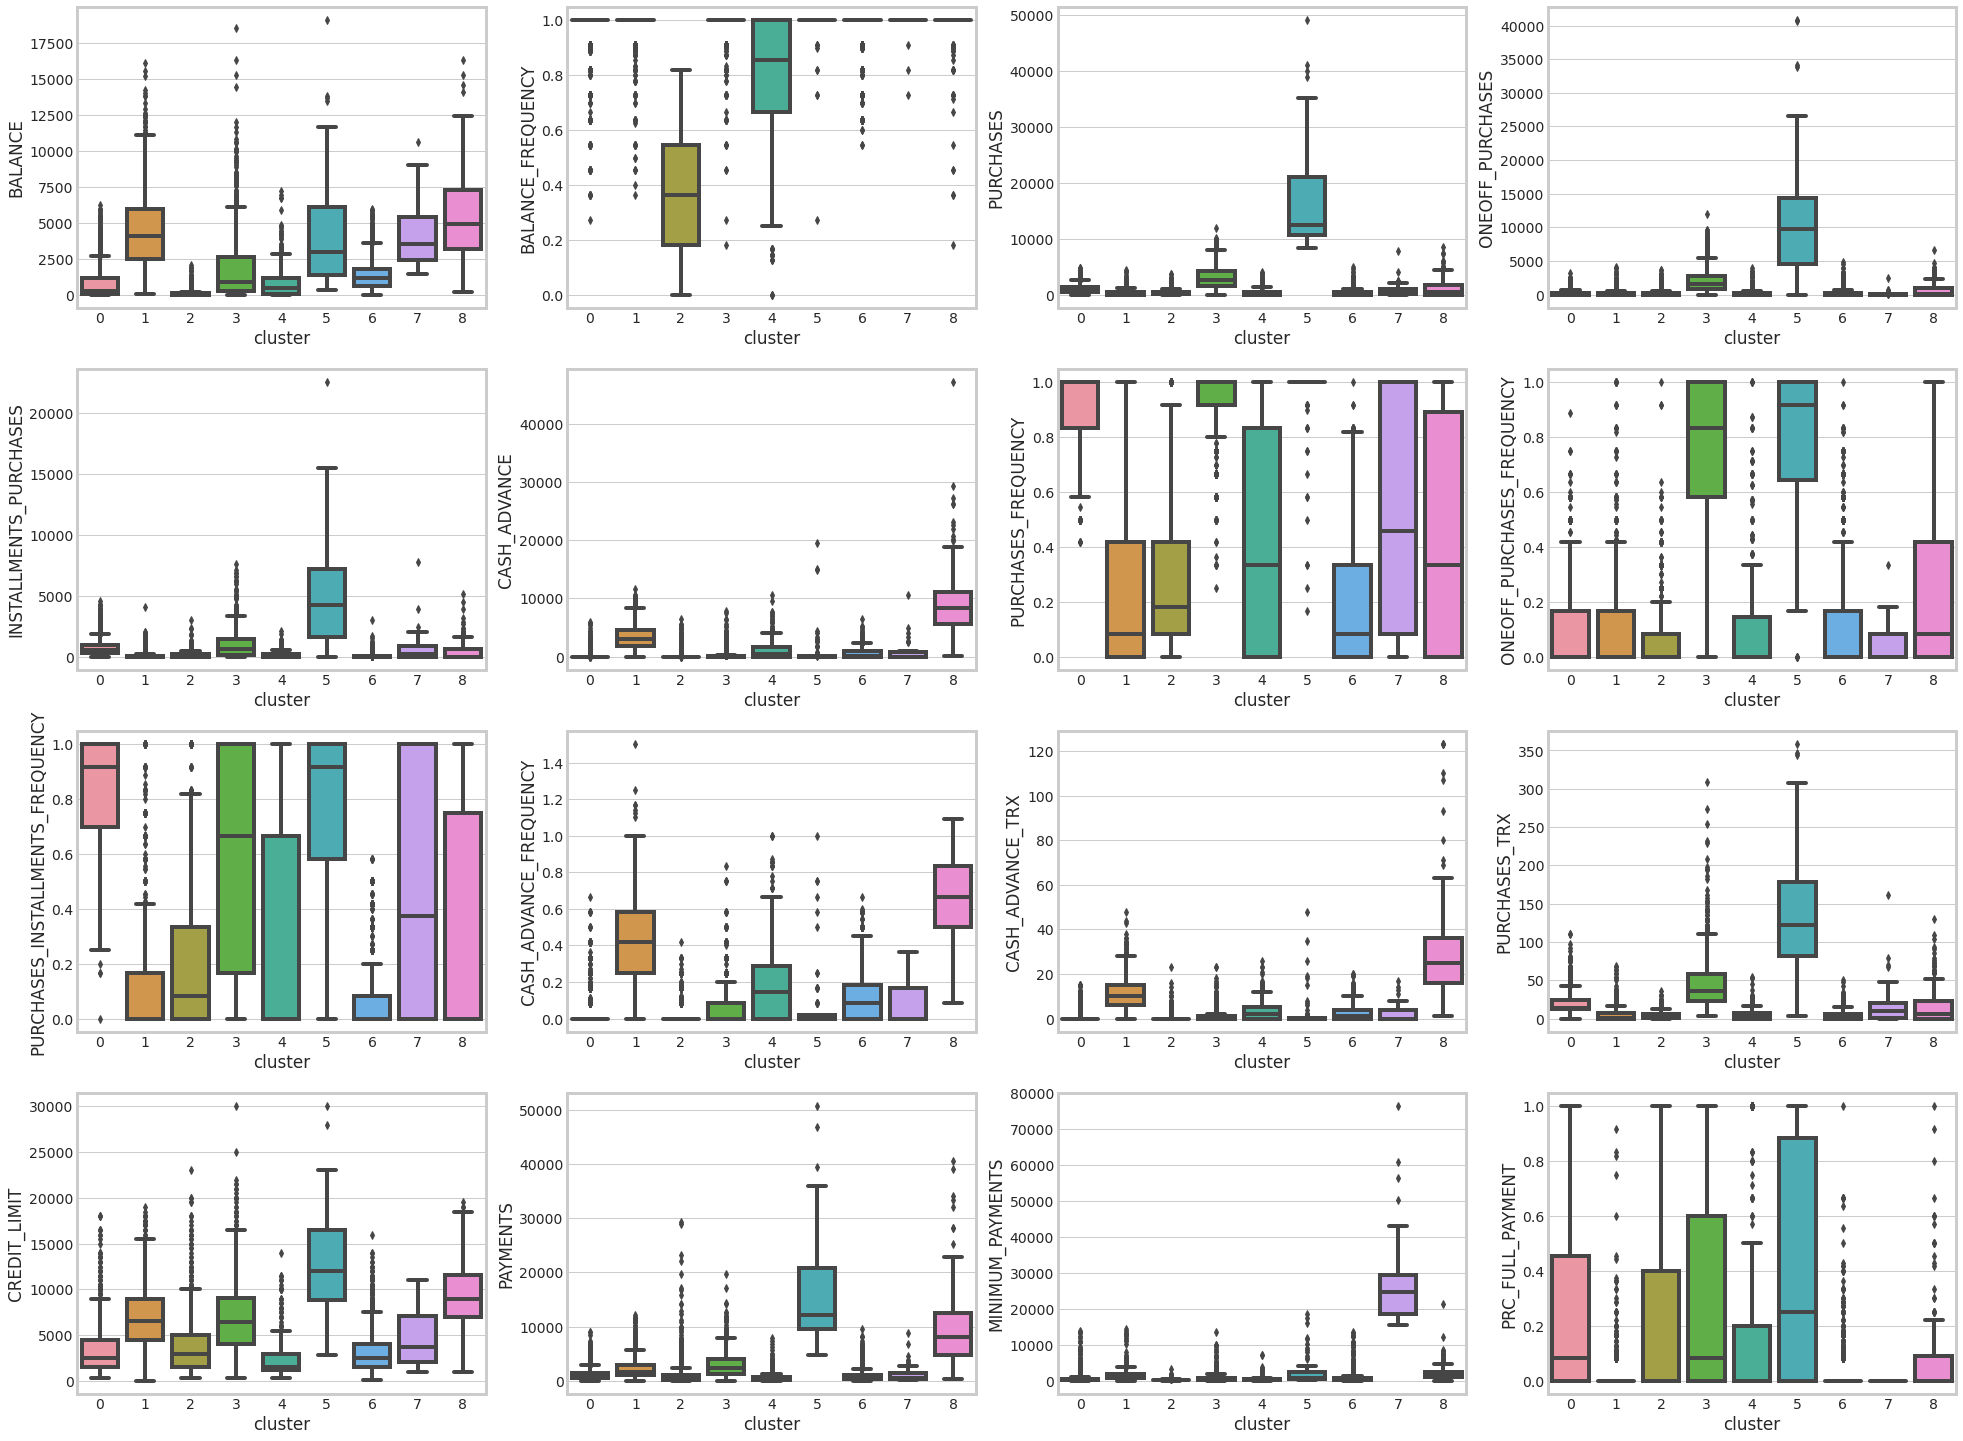

In [13]:
# Alternative code with nicer-looking plots

# selects only the numerical columns
# and calculates how the plot grid should be divided into subplots (nxn)
cols = df.select_dtypes('number').columns.drop(['TENURE', 'cluster'])
n = int(len(cols)**(1/2))

plt.figure(figsize=(30,30))
for i, col in enumerate(cols, 1):
    plt.subplot(n+1, n, i)
    sns.boxplot(x='cluster', y=col, data=df)

**Some Conclusions**:

- Cluster \#2 have very low balance and relatively low balance update frequency
- Cluster \#3 are one of the most frequent purchasers and one-off purchasers and often purchase in installments
- Cluster \#5 represents a small minority but are big spenders who make the highest purchases and one-off purchases and also make the most installment purchases
- Cluster \#6 represents the most common group but have one of the lowest credit limit, number of purchase transactions, purchases amount and percentage of fully paid payments.
- Cluster \#7 represents a small minority who have one of the lowest credit limit, the highest minimum payments (presumably the minimum to be paid at the end of the month) and the lowest percentage of payments fully paid, making them high risk credit card customers
- Cluster \#8 prefer paying cash in advance, and also have one of the higher total balance compared to the other groups

## Acknowledgment

Dataset source: https://www.kaggle.com/arjunbhasin2013/ccdata